# Necessary Imports and Settings

In [8]:
!export NLTK_DATA=/kuacc/users/bozyurt20/hpc_run/nltk_data

In [11]:
!printenv NLTK_DATA

In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import os
import nltk
import pandas as pd
import torch
import numpy as np
from jinja2 import Template
import pickle
from collections import defaultdict

from fuzzywuzzy import fuzz

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from util_research import *

import matplotlib.pyplot as plt

/kuacc/users/bozyurt20/.conda/envs/hf/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [10]:
from numba import cuda
cuda.select_device(0)
cuda.close()

CudaAPIError: [2] Call to cuDevicePrimaryCtxRetain results in CUDA_ERROR_OUT_OF_MEMORY

# Predictor Function

In [2]:
def predictor(text_injection_instance, write_in_file=False, out_path_prefix="Text_injection_T5_base_"):
    
    # prompt has the max number of tokens: 512, and we start at a " " char.
    
    model = text_injection_instance.model
    tokenizer = text_injection_instance.tokenizer
    device = text_injection_instance.device
    chapter1 = text_injection_instance.chapter1
    chapter2_tokenized = text_injection_instance.chapter2_tokenized
    tokens_to_append = text_injection_instance.tokens_to_append

    predictions = {}
    global no_story_in_context
    no_story_in_context = 0
    global okk
    okk = 0
    all_result_objects = {}
    for k in range(1, num_templates+1):
        all_result_objects[k] = []

    for item in dir_list_annotations:
        
        print(item)
        
        story_no = item[len("Andersen_story"):-len(".txt")]

        f = open(os.path.join(path_andersen, item), 'r') 
        story = f.read()
        f.close()
        
        predictions[item] = {}
        for k in range(1, num_templates+1):
            predictions[item][k] = {}

        if write_in_file:
            out_path = out_path_prefix + item[:-3] + "xlsx"
            writer = pd.ExcelWriter(out_path, engine='xlsxwriter')
            workbook = writer.book
            format = workbook.add_format({'text_wrap': True})

        annotations = all_annotations[item]

        paragraphs = story.split("\n\n")
        no_paragraphs = len(paragraphs)
        paragraph = paragraphs[0]
        paragraph = paragraph.replace("\n", " ")
        len_title = len(paragraph) + 2        

        i = 0 # line number in the annotation file
        j = 0 # paragraph number

        char_count = len_title   

        while i < len(annotations) and j < no_paragraphs:

            if char_count + 2 >= annotations[i][0]:

                line = annotations[i]

                character = line[1]
                gold_answer = line[2]
                grammatical_number = line[3]
                context = paragraph
                context = context.rstrip(", ;-\n")

                gold_locations = gold_answer.split("/")
                my_dic = {"Prompts": [gold_answer, "-", "-", "-"]}

                for k in range(1, num_templates+1):

                    y = char_count
                    x = y - 2600

                    if x < len_title:
                        text = story[len_title:y]

                    else:
                        x = story[x:y].find(" ") + x
                        text = story[x:y]

                    text = text_clean_ending(text)
                    text = remove_new_lines(text)

                    for num_chap2_tokens in tokens_to_append:
                        chapter2_part = tokenizer.decode(chapter2_tokenized[:num_chap2_tokens], skip_special_tokens=True)
                        chapter2_part = chapter2_part.rstrip(", ;-\n")
                        context = chapter1 + "\n" + text + "\n" + chapter2_part
                        prompt, context = create_prompt_clipped(tokenizer, k, context, character, grammatical_number, 512)
                        """ind1 = prompt.find(text)
                        if ind1 != -1:
                            prompt = prompt[:ind1] + "\n" + prompt[ind1:]
                        else:
                            okk += 1
                        ind2 = prompt.find(chapter2_part)
                        if ind2 != -1:
                            prompt = prompt[:ind2] + "\n" + prompt[ind2:]
                        else:
                            no_story_in_context += 1"""
                        inputs = tokenizer.encode(prompt, return_tensors="pt")
                        inputs = inputs.to(device)
                        with torch.no_grad():
                            outputs = model.generate(inputs)
                        out = tokenizer.decode(outputs[0], skip_special_tokens=True)
                        match1, match2 = exactly_or_fuzzily_matched(out, gold_locations)
                        predictions[item][k][num_chap2_tokens] = out
                        result_object = TextInjectionResults(prompt, out, gold_locations, character, k, num_chap2_tokens, story_no, match1, match2)
                        all_result_objects[k].append(result_object)
                        if write_in_file:
                            my_dic[prompt] = [out, num_chap2_tokens, match1, match2]
                  

                if write_in_file:
                    df = pd.DataFrame(data=my_dic, index=["output", "num_tokens_appended", "exact match?", "fuzzy match?"])
                    df = (df.T)
                    df.to_excel(writer, sheet_name=str(i+1))
                    worksheet = writer.sheets[str(i+1)]
                    for idx, col in enumerate(df):
                        max_len = 75
                        worksheet.set_column(idx, idx, max_len, format)

                i += 1
                print("line:", i)
            else:

                j += 1
                paragraph = paragraphs[j]
                paragraph = paragraph.replace("\n", " ")
                char_count += (len(paragraph) + 2)

        if write_in_file:
            writer.save()

    return predictions, all_result_objects



# All Annotations

In [3]:
all_annotations = {}

for item in dir_list_annotations:
    
    f = open(os.path.join(path_annotations, item), 'r')
    annotations = pd.read_csv(f, sep="\t")
    annotations = annotations.values
    f.close()
    
    all_annotations[item] = annotations

# Preparing the Dataset

In [2]:
class TextInjection():
    def __init__(self, model, tokenizer, device, chapter1, chapter2, tokens_to_append):
        self.model = model
        self.tokenizer = tokenizer
        self.model = self.model.to(device)
        self.device = device
        self.chapter1 = chapter1
        self.chapter2_tokenized = tokenizer.encode(chapter2)
        self.tokens_to_append = tokens_to_append

In [3]:
class TextInjectionResults():
    def __init__(self, prompt, model_out, gold_locations, character, k, tokens_appended, story_no, exact_match, fuzzy_match):
        self.prompt = prompt
        self.model_out = model_out
        self.gold_locations = gold_locations
        self.character = character
        self.k = k
        self.tokens_appended = tokens_appended
        self.story_no = story_no
        self.exact_match = exact_match
        self.fuzzy_match = fuzzy_match

In [6]:
path = "litbank/original/105_persuasion.txt"

with open(path, "r") as f:
    book = f.read()
    
indices = []
for i in range(1, 100):
    chapter_header = "Chapter " + str(i) + "\n\n"
    indices.append(book.find(chapter_header))

ind1 = indices[0]
ind2 = indices[1]
i = 2
chapters = []
while ind2 != -1:
    chapters.append(book[ind1:ind2])
    ind1 = ind2
    ind2 = indices[i]
    i += 1   

In [7]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

/kuacc/users/bozyurt20/.conda/envs/hf/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [49]:
tokens_to_append = [x for x in range(0, 501, 30)]

model = T5ForConditionalGeneration.from_pretrained("t5-base")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

chapter1 = remove_new_lines(chapters[0])
paragraph_start_ind = chapters[1].find("Mr Shepherd")
chapter2 = remove_new_lines(chapters[1][paragraph_start_ind:])


/kuacc/users/bozyurt20/.conda/envs/hf/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


NameError: name 'chapters' is not defined

In [6]:
tt = [x for x in range(0, 501, 30)]

In [7]:
tt

[0,
 30,
 60,
 90,
 120,
 150,
 180,
 210,
 240,
 270,
 300,
 330,
 360,
 390,
 420,
 450,
 480]

In [28]:
tokenizer.encode(" ok \n")

[3, 1825, 1]

In [11]:
x = tokenizer.encode("""Answer the question depending on the context.
Context: far. The Kellynch estate should be transmitted whole and entire, as he had received it. Their two confidential friends, Mr Shepherd, who lived in the neighbouring market town, and Lady Russell, were called to advise them; and both father and daughter seemed to expect that something should be struck out by one or the other to remove their embarrassments and reduce their expenditure, without involving the loss of any indulgence of taste or pride. Really, the largest green leaf in this country is a dock-leaf; if one holds it before one, it is like a whole apron, and if one holds it over one's head in rainy weather, it is almost as good as an umbrella, for it is so immensely large. The burdock never grows alone, but where there grows one there always grow several: it is a great delight, and all this delightfulness is snails' food. The great white snails which persons of quality in former times made fricassees of, ate, and said, “Hem, hem! how delicious!” for they thought it tasted so delicate--lived on dock-leaves, and therefore burdock seeds were sown. Now, there was an old manor-house, where they no longer ate snails, they were quite extinct; but the burdocks were not extinct, they grew and grew all over the walks and all the beds; they could not get the mastery over them--it was a whole forest of burdocks. Here and there stood an apple and a plum-tree, or else one never would have thought that it was a garden; all was burdocks, and there lived the two last venerable old snails. Mr Shepherd, a civil, cautious lawyer, who, whatever might be his hold or his views on Sir Walter, would rather have the disagreeable prompted by anybody else, excused himself from offering the slightest hint, and only begged leave to recommend an implicit reference to the excellent judgement of Lady Russell, from whose known good sense he fully expected to have just such resolute measures advised as he meant to see finally adopted. Lady Russell was most anxiously;
Question: Where are two old snails?;
Answer:""")

In [33]:
tokenizer.decode([5])

'.'

In [8]:
text_injection_instance = TextInjection(model, tokenizer, device, chapter1, chapter2, tokens_to_append)

predictions, all_result_objects = predictor(text_injection_instance, write_in_file=False, out_path_prefix="Text_injection_T5_base_")

Token indices sequence length is longer than the specified maximum sequence length for this model (2573 > 512). Running this sequence through the model will result in indexing errors


Andersen_story11.txt


/kuacc/users/bozyurt20/.conda/envs/hf/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


line: 1


KeyboardInterrupt: 

In [28]:
len(tokens_to_append)

13

In [ ]:
with open("Text_injection_T5_base_predictions.txt", "wb") as f:
    pickle.dump(predictions, f)

In [ ]:
with open("Text_injection_T5_base_all_result_objects.txt", "wb") as f:
    pickle.dump(all_result_objects, f)

In [27]:
predictions

{'Andersen_story11.txt': {0: {0: 'True',
   10: 'True',
   25: 'True',
   50: 'True',
   75: 'True',
   100: 'True',
   150: 'True',
   200: 'False',
   250: 'False',
   300: 'False',
   350: 'False',
   400: 'True',
   450: 'False'},
  1: {},
  2: {},
  3: {},
  4: {},
  5: {},
  6: {},
  7: {},
  8: {},
  9: {},
  10: {},
  11: {},
  12: {},
  13: {},
  14: {},
  15: {},
  16: {},
  17: {},
  18: {},
  19: {},
  20: {},
  21: {},
  22: {}}}

# Get the Results

In [4]:
with open("Text_injection_T5_base_predictions.txt", "rb") as f:
    predictions = pickle.load(f)

In [5]:
with open("Text_injection_T5_base_all_result_objects.txt", "rb") as f:
    all_result_objects = pickle.load(f)

In [38]:
len(all_result_objects[1])

4233

# Distance Graph

In [8]:
exact_match_distances = {}
fuzzy_match_distances = {}
non_exact_match_distances = {}
non_fuzzy_match_distances = {}

number_of_questions_asked = {}
not_in_context = {}
for k in all_result_objects.keys():

    exact_match_distances[k] = []
    fuzzy_match_distances[k] = []
    non_exact_match_distances[k] = []
    non_fuzzy_match_distances[k] = []

    #for num_chap2_tokens in all_result_objects[k].keys():
    number_of_questions_asked[k] = 0
        
    for result_object in all_result_objects[k]: #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        
        number_of_questions_asked[k] += 1

        distances = [1e9 for _ in range(len(gold_locations))]

        for num_loc, gold_location in enumerate(gold_locations):
            loc_mention = prompt.rfind(gold_location)
            if loc_mention != -1:
                loc_mention += len(gold_location)
                no_tokens = len(tokenizer.encode(prompt[loc_mention:]))
                #abs_inv_recency = len(prompt) - loc_mention
                #distances[num_loc] = abs_inv_recency
                distances[num_loc] = no_tokens
                
        if min(distances) < 1e8:
            
            if match1 == "Yes":
                exact_match_distances[k].append(min(distances))
            else:
                non_exact_match_distances[k].append(min(distances))

            if match2 == "Yes":
                fuzzy_match_distances[k].append(min(distances))
            else:                     
                non_fuzzy_match_distances[k].append(min(distances))

In [9]:
prompt_no = 13
loc_mention_graph = []

for dist in exact_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 1))
    
for dist in non_exact_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 0))

In [11]:
sum(exact_match_distances[prompt_no])/len(exact_match_distances[prompt_no])

ZeroDivisionError: division by zero

In [12]:
len(exact_match_distances[prompt_no])

0

In [13]:
sum(non_exact_match_distances[prompt_no])/len(non_exact_match_distances[prompt_no])

294.2927818329278

In [14]:
len(non_exact_match_distances[prompt_no])

2466

In [ ]:
all_distances = [x[0] for x in loc_mention_graph]

In [ ]:
all_distances = sorted(all_distances)

In [ ]:
min(all_distances)

In [ ]:
all_distances[-1]

In [15]:
grap = defaultdict(list)
num_data_points = {}
for tupl in loc_mention_graph:
    for i in range(10):
        if 100*i<=tupl[0]<100*i+100:
            grap[i].append(tupl)
for i in range(10):
    num_data_points[i] = len(grap[i])
    if len(grap[i]) != 0 and len(grap[i]) > 5:
        grap[i] = sum([tupl[1] == 1 for tupl in grap[i]]) / len(grap[i]) * 100
    else:
        grap[i] = 0
grap_tuples = [(key, grap[key]) for key in grap]

([<matplotlib.axis.XTick at 0x2b1bd49d8af0>,
 [Text(0, 0, '0-100\n50000'),
  Text(1, 0, '100-200'),
  Text(2, 0, '200-300'),
  Text(3, 0, '300-400'),
  Text(4, 0, '400-500'),
  Text(5, 0, '500-600'),
  Text(6, 0, '600-700'),
  Text(7, 0, '700-800'),
  Text(8, 0, '800-900'),
  Text(9, 0, '900-1000')])

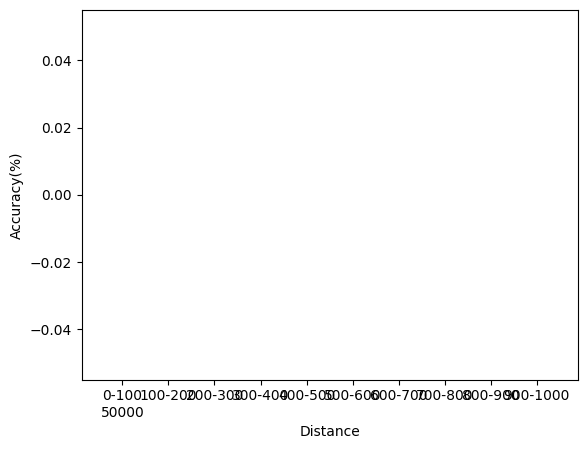

In [16]:
plt.bar(*zip(*grap_tuples))
plt.xlabel("Distance")
plt.ylabel("Accuracy(%)")
plt.xticks(np.arange(10), ['0-100\n50000', '100-200', '200-300', '300-400', "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000"])

In [17]:
exact_matches = {}

for k in all_result_objects.keys():
    exact_matches[k] = []
    
    for j, result_object in enumerate(all_result_objects[k]): #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        
        if match1 == "Yes":
            exact_matches[k].append(1)
        else:
            exact_matches[k].append(0)
            

In [18]:
accuracies = {}
for k in all_result_objects.keys():
    if exact_matches[k] != []:
        accuracies[k] = sum(exact_matches[k])/len(exact_matches[k])

In [19]:
accuracies

{1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.00023623907394283014,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0}

In [20]:
exact_matches = {}

for k in all_result_objects.keys():
    exact_matches[k] = {}
    
    for no_tok in tokens_to_append:
        exact_matches[k][no_tok] = []
    
    for j, result_object in enumerate(all_result_objects[k]): #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        no_tok = result_object.tokens_appended

        if match1 == "Yes":
            exact_matches[k][no_tok].append(1)
        else:
            exact_matches[k][no_tok].append(0)



NameError: name 'tokens_to_append' is not defined

In [75]:
accuracies_no_tok_appended = {}
for k in all_result_objects.keys():
    accuracies_no_tok_appended[k] = {}
    for no_tok in exact_matches[k]:
        if exact_matches[k][no_tok] != []:
            accuracies_no_tok_appended[k][no_tok] = sum(exact_matches[k][no_tok])/len(exact_matches[k][no_tok])

In [76]:
for k in all_result_objects.keys():
    
    if accuracies_no_tok_appended[k]:
        print(k)
        print(accuracies_no_tok_appended[k])

1
{0: 0.0, 30: 0.0, 60: 0.0, 90: 0.0, 120: 0.0, 150: 0.0, 180: 0.0, 210: 0.0, 240: 0.0, 270: 0.0, 300: 0.0, 330: 0.0, 360: 0.0, 390: 0.0, 420: 0.0, 450: 0.0, 480: 0.0}
2
{0: 0.0, 30: 0.0, 60: 0.0, 90: 0.0, 120: 0.0, 150: 0.0, 180: 0.0, 210: 0.0, 240: 0.0, 270: 0.0, 300: 0.0, 330: 0.0, 360: 0.0, 390: 0.0, 420: 0.0, 450: 0.0, 480: 0.0}
3
{0: 0.0, 30: 0.0, 60: 0.0, 90: 0.0, 120: 0.0, 150: 0.0, 180: 0.0, 210: 0.0, 240: 0.0, 270: 0.0, 300: 0.0, 330: 0.0, 360: 0.0, 390: 0.0, 420: 0.0, 450: 0.0, 480: 0.0}
4
{0: 0.0, 30: 0.0, 60: 0.0, 90: 0.0, 120: 0.0, 150: 0.0, 180: 0.0, 210: 0.0, 240: 0.0, 270: 0.0, 300: 0.0, 330: 0.004016064257028112, 360: 0.0, 390: 0.0, 420: 0.0, 450: 0.0, 480: 0.0}
5
{0: 0.0, 30: 0.0, 60: 0.0, 90: 0.0, 120: 0.0, 150: 0.0, 180: 0.0, 210: 0.0, 240: 0.0, 270: 0.0, 300: 0.0, 330: 0.0, 360: 0.0, 390: 0.0, 420: 0.0, 450: 0.0, 480: 0.0}
6
{0: 0.0, 30: 0.0, 60: 0.0, 90: 0.0, 120: 0.0, 150: 0.0, 180: 0.0, 210: 0.0, 240: 0.0, 270: 0.0, 300: 0.0, 330: 0.0, 360: 0.0, 390: 0.0, 420: 

In [16]:
prompt_no = 13
loc_mention_graph = []

for dist in fuzzy_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 1))
    
for dist in non_fuzzy_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 0))

In [78]:
sum(fuzzy_match_distances[prompt_no])/len(fuzzy_match_distances[prompt_no])

244.42857142857142

In [79]:
len(fuzzy_match_distances[prompt_no])

266

In [80]:
sum(non_fuzzy_match_distances[prompt_no])/len(non_fuzzy_match_distances[prompt_no])

300.3218181818182

In [81]:
len(non_fuzzy_match_distances[prompt_no])

2200

In [82]:
all_distances = [x[0] for x in loc_mention_graph]

In [83]:
all_distances = sorted(all_distances)

In [84]:
min(all_distances)

24

In [85]:
all_distances[-1]

502

In [30]:
grap = defaultdict(list)
num_data_points = {}
for tupl in loc_mention_graph:
    for i in range(11):
        if 50*i<=tupl[0]<50*i+50:
            grap[i].append(tupl)
for i in range(11):
    num_data_points[i] = len(grap[i])
    if len(grap[i]) != 0 and len(grap[i]) > 5:
        grap[i] = sum([tupl[1] == 1 for tupl in grap[i]]) / len(grap[i]) * 100
    else:
        grap[i] = 0
grap_tuples = [(key, grap[key]) for key in grap]

In [31]:
grap_tuples

[(3, 17.60299625468165),
 (4, 14.074074074074074),
 (1, 15.032679738562091),
 (5, 16.541353383458645),
 (6, 8.125),
 (7, 7.741935483870968),
 (8, 5.902777777777778),
 (9, 3.8461538461538463),
 (2, 15.675675675675677),
 (0, 8.771929824561402),
 (10, 0.0)]

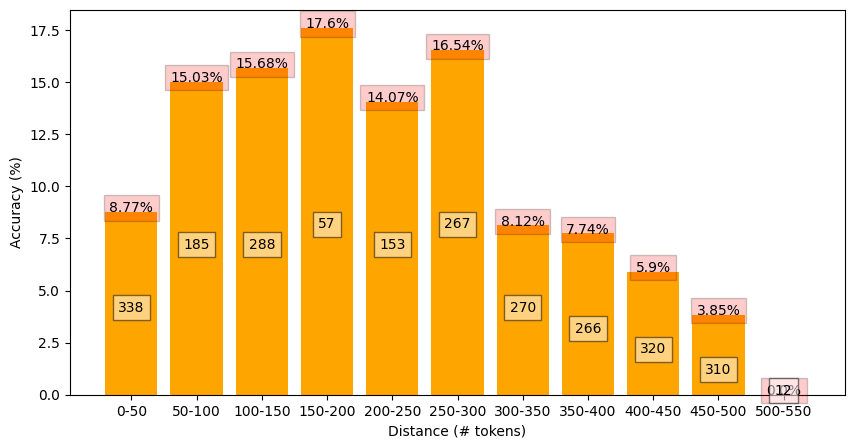

In [33]:
x_points, y_points = zip(*grap_tuples)
plt.figure(figsize = (10, 5))
plt.bar(x_points, y_points, color="orange")
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i], str(round(y_points[i],2)) + "%", ha = 'center', bbox = dict(facecolor = 'red', alpha =.2))
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i]//2, num_data_points[i],  ha = 'center',
             bbox = dict(facecolor = 'white', alpha = .5))
plt.xlabel("Distance (# tokens)")
plt.ylabel("Accuracy (%)")

plt.xticks(np.arange(11), ['0-50', '50-100', '100-150', '150-200', "200-250", "250-300", "300-350", "350-400", "400-450", "450-500", "500-550"])
plt.savefig('T5_base_fuzzy.png')

In [20]:
grap = defaultdict(list)
num_data_points = {}
for tupl in loc_mention_graph:
    for i in range(10):
        if 100*i<=tupl[0]<100*i+100:
            grap[i].append(tupl)
for i in range(10):
    num_data_points[i] = len(grap[i])
    if len(grap[i]) != 0 and len(grap[i]) > 5:
        grap[i] = sum([tupl[1] == 1 for tupl in grap[i]]) / len(grap[i]) * 100
    else:
        grap[i] = 0
grap_tuples = [(key, grap[key]) for key in grap]

In [21]:
with open("Text_injection_t5_base_graph_points.txt", "wb") as f:
    pickle.dump(grap_tuples, f)

([<matplotlib.axis.XTick at 0x2b1bd65540a0>,
 [Text(0, 0, '0-50'),
  Text(1, 0, '50-100'),
  Text(2, 0, '100-150'),
  Text(3, 0, '150-200'),
  Text(4, 0, '200-250'),
  Text(5, 0, '250-300'),
  Text(6, 0, '300-350'),
  Text(7, 0, '350-400'),
  Text(8, 0, '400-450'),
  Text(9, 0, '450-500')])

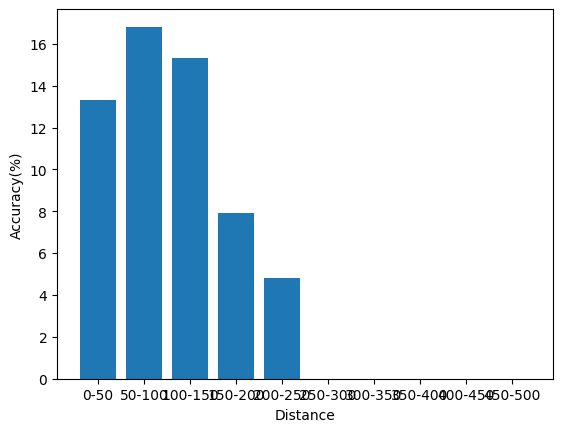

In [34]:
plt.bar(*zip(*grap_tuples))
plt.xlabel("Distance")
plt.ylabel("Accuracy(%)")
plt.xticks(np.arange(10), ['0-50', '50-100', '100-150', '150-200', "200-250", "250-300", "300-350", "350-400", "400-450", "450-500"])

([<matplotlib.axis.XTick at 0x2ac4e81a5640>,
 [Text(0, 0, '0-50'),
  Text(1, 0, '50-100'),
  Text(2, 0, '100-150'),
  Text(3, 0, '150-200'),
  Text(4, 0, '200-250'),
  Text(5, 0, '250-300'),
  Text(6, 0, '300-350'),
  Text(7, 0, '350-400'),
  Text(8, 0, '400-450'),
  Text(9, 0, '450-500')])

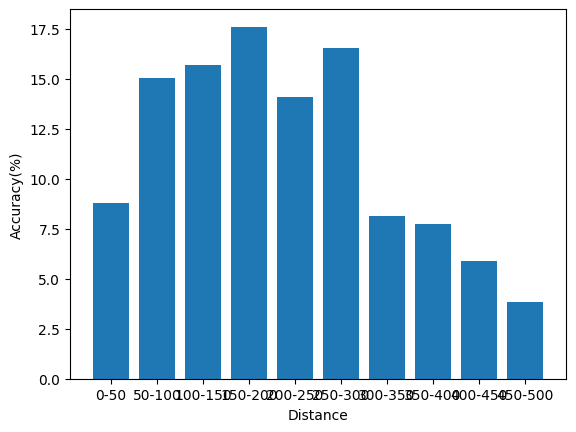

In [90]:
plt.bar(*zip(*grap_tuples))
plt.xlabel("Distance")
plt.ylabel("Accuracy(%)")
plt.xticks(np.arange(10), ['0-50', '50-100', '100-150', '150-200', "200-250", "250-300", "300-350", "350-400", "400-450", "450-500"])

In [34]:
fuzzy_matches = {}

for k in all_result_objects.keys():
    fuzzy_matches[k] = []
    
    for j, result_object in enumerate(all_result_objects[k]): #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        
        if match2 == "Yes":
            fuzzy_matches[k].append(1)
        else:
            fuzzy_matches[k].append(0)
            

In [35]:
accuracies = {}
for k in all_result_objects.keys():
    if fuzzy_matches[k] != []:
        accuracies[k] = sum(fuzzy_matches[k])/len(fuzzy_matches[k])

In [36]:
accuracies

{1: 0.0004724781478856603,
 2: 0.023387668320340185,
 3: 0.07583274273564848,
 4: 0.0784313725490196,
 5: 0.07748641625324829,
 6: 0.07795889440113395,
 7: 0.07559650366170564,
 8: 0.07559650366170564,
 9: 0.1552090715804394,
 10: 0.15946137491141035,
 11: 0.11906449326718639,
 12: 0.0009449562957713206,
 13: 0.07158043940467754,
 14: 0.0760689818095913,
 15: 0.07866761162296244,
 16: 0.08079376328844791,
 17: 0.0744153082919915,
 18: 0.07748641625324829,
 19: 0.07725017717930546,
 20: 0.14505079140089772,
 21: 0.1552090715804394,
 22: 0.13772738010866997,
 23: 0.08197495865816205}

In [55]:
fuzzy_matches = {}

for k in all_result_objects.keys():
    fuzzy_matches[k] = {}
    
    for no_tok in tokens_to_append:
        fuzzy_matches[k][no_tok] = []
    
    for j, result_object in enumerate(all_result_objects[k]): #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        no_tok = result_object.tokens_appended

        if match2 == "Yes":
            fuzzy_matches[k][no_tok].append(1)
        else:
            fuzzy_matches[k][no_tok].append(0)



In [57]:
accuracies_no_tok_appended = {}
for k in all_result_objects.keys():
    accuracies_no_tok_appended[k] = {}
    for no_tok in fuzzy_matches[k]:
        if fuzzy_matches[k][no_tok] != []:
            accuracies_no_tok_appended[k][no_tok] = sum(fuzzy_matches[k][no_tok])/len(fuzzy_matches[k][no_tok])

In [58]:
for k in all_result_objects.keys():
    
    if accuracies_no_tok_appended[k]:
        print(k)
        print(accuracies_no_tok_appended[k])

1
{0: 0.0, 30: 0.004016064257028112, 60: 0.0, 90: 0.004016064257028112, 120: 0.0, 150: 0.0, 180: 0.0, 210: 0.0, 240: 0.0, 270: 0.0, 300: 0.0, 330: 0.0, 360: 0.0, 390: 0.0, 420: 0.0, 450: 0.0, 480: 0.0}
2
{0: 0.05622489959839357, 30: 0.08032128514056225, 60: 0.03614457831325301, 90: 0.05220883534136546, 120: 0.0642570281124498, 150: 0.028112449799196786, 180: 0.04417670682730924, 210: 0.024096385542168676, 240: 0.004016064257028112, 270: 0.004016064257028112, 300: 0.0, 330: 0.0, 360: 0.004016064257028112, 390: 0.0, 420: 0.0, 450: 0.0, 480: 0.0}
3
{0: 0.024096385542168676, 30: 0.08433734939759036, 60: 0.08433734939759036, 90: 0.07228915662650602, 120: 0.08433734939759036, 150: 0.07630522088353414, 180: 0.10441767068273092, 210: 0.08835341365461848, 240: 0.08433734939759036, 270: 0.05220883534136546, 300: 0.08433734939759036, 330: 0.08032128514056225, 360: 0.09236947791164658, 390: 0.08433734939759036, 420: 0.10441767068273092, 450: 0.04819277108433735, 480: 0.040160642570281124}
4
{0: 0.

# Visualization

In [22]:
with open("Text_injection_T5_base_all_result_objects.txt", "rb") as f:
    all_result_objects = pickle.load(f)

In [23]:
for k in [13]: #all_result_objects.keys():
    
    out_path = "text_injection_t5_base_outputs_k" + str(k) + ".xlsx"
    writer = pd.ExcelWriter(out_path, engine='xlsxwriter')
    workbook = writer.book
    format = workbook.add_format({'text_wrap': True})
    my_dic = {"Prompts": ["-", "-", "-", "-", "-"]}
    
    for j, result_object in enumerate(all_result_objects[k]): #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        num_chap2_tokens = result_object.tokens_appended
        
        my_dic[prompt] = [gold_locations, out, num_chap2_tokens, match1, match2]
        
    df = pd.DataFrame(data=my_dic, index=["gold_locations", "output", "num_tokens_appended", "exact match?", "fuzzy match?"])
    df = (df.T)
    df.to_excel(writer, sheet_name="output")
    worksheet = writer.sheets["output"]
    for idx, col in enumerate(df):
        max_len = 75
        worksheet.set_column(idx, idx, max_len, format)

    writer.save()



/tmp/ipykernel_213939/1516570849.py:28: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [ ]:
for k in all_result_objects.keys():

    exact_match_distances[k] = []
    fuzzy_match_distances[k] = []
    non_exact_match_distances[k] = []
    non_fuzzy_match_distances[k] = []

    for num_chap2_tokens in all_result_objects[k].keys():
        
        for result_object in all_result_objects[k][num_chap2_tokens]:
            
            prompt = result_object.prompt
            out = result_object.model_out
            gold_locations = result_object.gold_locations
            match1 = result_object.exact_match
            match2 = result_object.fuzzy_match
            
            distances = [1e9 for _ in range(len(gold_locations))]
            
            for num_loc, gold_location in enumerate(gold_locations):
                loc_mention = prompt.rfind(gold_location)
                if loc_mention != -1:
                    loc_mention += len(gold_location)
                    abs_inv_recency = len(prompt) - loc_mention
                    distances[num_loc] = abs_inv_recency
                    
            if match1 == "Yes":
                exact_match_distances[k].append(min(distances))
            else:
                if not min(distances) < 1e8:
                    pass
                else:                      
                    non_exact_match_distances[k].append(min(distances))
            
            if match2 == "Yes":
                fuzzy_match_distances[k].append(min(distances))
            else:
                if not min(distances) < 1e8:
                    pass
                else:                      
                    non_fuzzy_match_distances[k].append(min(distances))

In [299]:
prompt_no = 13
loc_mention_graph = []

for dist in exact_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 1))
    
for dist in non_exact_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 0))

In [300]:
sum(exact_match_distances[prompt_no])/len(exact_match_distances[prompt_no])

667.5952380952381

In [ ]:
len(exact_match_distances[prompt_no])

In [301]:
sum(non_exact_match_distances[prompt_no])/len(non_exact_match_distances[prompt_no])

497.5238095238095

In [ ]:
len(non_exact_match_distances[prompt_no])

In [204]:
all_distances = [x[0] for x in loc_mention_graph]

In [205]:
all_distances = sorted(all_distances)

In [155]:
min(all_distances)

10

In [160]:
all_distances[-1]

3451

In [304]:
grap = defaultdict(list)
for tupl in loc_mention_graph:
    for i in range(10):
        if 350*i<=tupl[0]<350*i+350:
            grap[i].append(tupl)
for i in range(10):
    if len(grap[i]) != 0 and len(grap[i]) > 5:
        grap[i] = sum([tupl[1] == 1 for tupl in grap[i]]) / len(grap[i]) * 100
    else:
        grap[i] = 0
grap_tuples = [(key, grap[key]) for key in grap]

([<matplotlib.axis.XTick at 0x2b5f830886d0>,
 [Text(0, 0, '0-350'),
  Text(1, 0, '350-700'),
  Text(2, 0, '700-1050'),
  Text(3, 0, ''),
  Text(4, 0, '1400-1750'),
  Text(5, 0, ''),
  Text(6, 0, '2100-2450'),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, '3150-3500')])

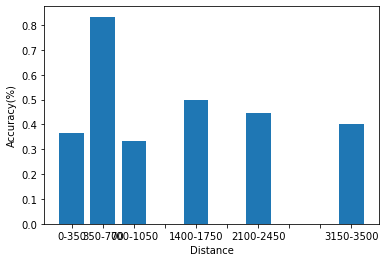

In [309]:
plt.bar(*zip(*grap_tuples))
plt.xlabel("Distance")
plt.ylabel("Accuracy(%)")
plt.xticks(np.arange(10), ['0-350', '350-700', '700-1050', "", "1400-1750","", "2100-2450", "", "", "3150-3500"])